In [1]:
1+1

2

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

import os
# import streamlit as st

from dotenv import load_dotenv
from langchain_community.document_loaders import Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
# from pinecone import Pinecone
# from langchain_pinecone import PineconeVectorStore
from langchain import hub
from langchain.chains import RetrievalQA
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate

In [4]:
from langchain_community.document_loaders import Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=200,
)

loader = Docx2txtLoader('./tax.docx')
document_list = loader.load_and_split(text_splitter=text_splitter)

In [5]:
document_list[52]

Document(metadata={'source': './tax.docx'}, page_content='제55조(세율) ①거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n\n| 종합소득 과세표준          | 세율                                         |\n\n|-------------------|--------------------------------------------|\n\n| 1,400만원 이하     | 과세표준의 6퍼센트                             |\n\n| 1,400만원 초과     5,000만원 이하     | 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)  |\n\n| 5,000만원 초과   8,800만원 이하     | 624만원 + (5,000만원을 초과하는 금액의 24퍼센트) |\n\n| 8,800만원 초과 1억5천만원 이하    | 1,536만원 + (8,800만원을 초과하는 금액의 35퍼센트)|\n\n| 1억5천만원 초과 3억원 이하         | 3,706만원 + (1억5천만원을 초과하는 금액의 38퍼센트)|\n\n| 3억원 초과    5억원 이하         | 9,406만원 + (3억원을 초과하는 금액의 38퍼센트)   |\n\n| 5억원 초과      10억원 이하        | 1억 7,406만원 + (5억원을 초과하는 금액의 42퍼센트)|\n\n| 10억원 초과        | 3억 8,406만원 + (10억원을 초과하는 금액의 45퍼센트)|\n\n\n\n\n\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 “퇴직소득 산출세액”이라 한다)으로 한다.<개정 20

In [6]:
from langchain_openai import OpenAIEmbeddings

# OpenAI에서 제공하는 Embedding Model을 활용해서 `chunk`를 vector화
embedding = OpenAIEmbeddings(model='text-embedding-3-large')

In [7]:
#vector DB

from langchain_chroma import Chroma

# 데이터를 처음 저장할 때
# database = Chroma.from_documents(
#     documents=document_list, 
#     embedding=embedding, 
#     collection_name="chroma-tax",
#     persist_directory="./chroma_db"
#     )

database = Chroma(
    embedding_function=embedding,
    collection_name="chroma-tax",
    persist_directory="./chroma_db",
)


In [8]:
query = "연봉 5천만원 직장인 종합소득세는?"

In [9]:
retriever = database.as_retriever(search_kwargs={"k": 4})
retriever.invoke(query)

[Document(metadata={'source': './tax.docx'}, page_content='나. 그 밖의 배당소득에 대해서는 100분의 14\n\n3. 원천징수대상 사업소득에 대해서는 100분의 3. 다만, 외국인 직업운동가가 한국표준산업분류에 따른 스포츠 클럽 운영업 중 프로스포츠구단과의 계약(계약기간이 3년 이하인 경우로 한정한다)에 따라 용역을 제공하고 받는 소득에 대해서는 100분의 20으로 한다.\n\n4. 근로소득에 대해서는 기본세율. 다만, 일용근로자의 근로소득에 대해서는 100분의 6으로 한다.\n\n5. 공적연금소득에 대해서는 기본세율\n\n5의2.제20조의3제1항제2호나목 및 다목에 따른 연금계좌 납입액이나 운용실적에 따라 증가된 금액을 연금수령한 연금소득에 대해서는 다음 각 목의 구분에 따른 세율. 이 경우 각 목의 요건을 동시에 충족하는 때에는 낮은 세율을 적용한다.\n\n가. 연금소득자의 나이에 따른 다음의 세율\n\n\n\n나. 삭제<2014. 12. 23.>\n\n다. 사망할 때까지 연금수령하는 대통령령으로 정하는 종신계약에 따라 받는 연금소득에 대해서는 100분의 4\n\n5의3. 제20조의3제1항제2호가목에 따라 퇴직소득을 연금수령하는 연금소득에 대해서는 다음 각 목의 구분에 따른 세율. 이 경우 연금 실제 수령연차 및 연금외수령 원천징수세율의 구체적인 내용은 대통령령으로 정한다.\n\n가. 연금 실제 수령연차가 10년 이하인 경우: 연금외수령 원천징수세율의 100분의 70\n\n나. 연금 실제 수령연차가 10년을 초과하는 경우: 연금외수령 원천징수세율의 100분의 60\n\n6. 기타소득에 대해서는 다음에 규정하는 세율. 다만, 제8호를 적용받는 경우는 제외한다.\n\n가. 제14조제3항제8호라목 및 마목에 해당하는 소득금액이 3억원을 초과하는 경우 그 초과하는 분에 대해서는 100분의 30\n\n나. 제21조제1항제18호 및 제21호에 따른 기타소득에 대해서는 100분의 15\n\n다. 삭제<2014. 12. 2

In [10]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [11]:
llm = ChatOpenAI(model='gpt-4o')

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt}
)

ai_message = qa_chain.invoke({"query": query})

In [12]:
chain = prompt | llm | StrOutputParser()
tax_chain = {"query": chain} | qa_chain

In [13]:
query = "연봉 5천만원 직장인의 소득세는?"
ai_message = qa_chain.invoke({"query": query})
ai_message


{'query': '연봉 5천만원 직장인의 소득세는?',
 'result': '연봉 5천만 원의 직장인의 소득세는 기본세율이 적용됩니다. 기본세율은 소득 구간에 따라 차등 적용되며, 정확한 세율과 세금 금액은 소득세법의 세율표에 따라 계산해야 합니다. 따라서 구체적인 소득세 금액은 세율표를 참고해야 정확히 알 수 있습니다.'}

In [14]:
from langchain_core.tools import tool
from typing import List
from langchain_community.tools import TavilySearchResults

#툴 만들기
@tool
def search_law(query: str) -> List[str]:
    """
   세법에서 정보를 검색합니다.  
    """
    docs = database.similarity_search(query, k=2)
    
    formatted_docs = "\n--\n".join([
        f'<Document href="{doc.metadata["source"]}">\n{doc.page_content}\n</Document>'
        for doc in docs
            
    ])
    
    if len(formatted_docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."


@tool
def search_web(query: str) -> str:      #쿼리가 들어오면 문자열로 답
    """
    데이터 베이스에 존제하지 않는 정보 또는 최신 정보를 인터넷으로 검색합니다.
    """
    
    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)
    
    # print(docs)
    formatted_docs = "\n\n--\n\n".join(
        [
            f"<Document href='{doc['url']}'>\n{doc['content']}\n</Document>"
            for doc in docs            
        ])
    
    if len(formatted_docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."



In [15]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(       #자신의 지식을 가지고 검색
    model="gpt-4o-mini",
    streaming=True,
)

tools = [search_law, search_web]

#툴 두개를 기반으로 검색
llm_with_tools = llm.bind_tools(tools=tools)



In [16]:
from langchain_core.messages import AIMessage, HumanMessage

#도구 호출 (어떤 툴을 호출했는지 정보)
tool_call = llm_with_tools.invoke(
    [HumanMessage("관세기간은 언제부터 언제까지 인가요?")]
)

print(tool_call.additional_kwargs)

{'tool_calls': [{'index': 0, 'id': 'call_zBZjqzXFogAQM3kxDvIsPzED', 'function': {'arguments': '{"query":"관세기간"}', 'name': 'search_law'}, 'type': 'function'}]}


In [17]:
#도구 호출 (어떤 툴을 호출했는지 정보)
tool_call = llm_with_tools.invoke(
    [HumanMessage("langgranph는 무엇인가요?")]
)

print(tool_call.additional_kwargs)

{'tool_calls': [{'index': 0, 'id': 'call_FG5QIHwevzmKcUgwUnPbljUo', 'function': {'arguments': '{"query":"langgranph"}', 'name': 'search_web'}, 'type': 'function'}]}


In [18]:

from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=tools)

In [19]:
tool_call = llm_with_tools.invoke(
    [HumanMessage("연봉 5천만원 직장인의 소득세는 얼마인가요?")]
)

tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_0i8ZovgFEX5Oc8n8eONYMOjT', 'function': {'arguments': '{"query":"연봉 5000만원 소득세"}', 'name': 'search_law'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef'}, id='run--1d73d4e6-60ac-41a6-afce-11d2f4c8732d-0', tool_calls=[{'name': 'search_law', 'args': {'query': '연봉 5000만원 소득세'}, 'id': 'call_0i8ZovgFEX5Oc8n8eONYMOjT', 'type': 'tool_call'}])

In [20]:
results = tool_node.invoke({"messages": [tool_call]})

for result in results['messages']:
    print(result.content)
    print()

<Document href="./tax.docx">
④ 관할세무서장 또는 지방국세청장은 주소ㆍ거소 또는 사업장의 이동이 빈번하다고 인정되는 지역의 납세의무가 있는 자에 대해서는 제1항과 제2항을 준용하여 대통령령으로 정하는 바에 따라 수시부과할 수 있다.

⑤ 수시부과 절차와 그 밖에 필요한 사항은 대통령령으로 정한다.

[전문개정 2009. 12. 31.]



제83조(과세표준과 세액의 통지) 납세지 관할 세무서장 또는 지방국세청장은 제80조에 따라 거주자의 과세표준과 세액을 결정 또는 경정한 경우에는 그 내용을 해당 거주자 또는 상속인에게 대통령령으로 정하는 바에 따라 서면으로 통지하여야 한다. 다만, 제42조에 따라 과세표준과 세액의 결정 또는 경정을 한 경우에는 지체 없이 통지하여야 한다.

[전문개정 2009. 12. 31.]



제84조(기타소득의 과세최저한) 기타소득이 다음 각 호의 어느 하나에 해당하면 그 소득에 대한 소득세를 과세하지 아니한다. <개정 2014. 12. 23., 2015. 12. 15., 2022. 12. 31.>

1. 제21조제1항제4호에 따른 환급금으로서 건별로 승마투표권, 승자투표권, 소싸움경기투표권, 체육진흥투표권의 권면에 표시된 금액의 합계액이 10만원 이하이고 다음 각 목의 어느 하나에 해당하는 경우

가. 적중한 개별투표당 환급금이 10만원 이하인 경우

나. 단위투표금액당 환급금이 단위투표금액의 100배 이하이면서 적중한 개별투표당 환급금이 200만원 이하인 경우

2. 제14조제3항제8호라목에 따른 복권 당첨금(복권당첨금을 복권 및 복권 기금법령에 따라 분할하여 지급받는 경우에는 분할하여 지급받는 금액의 합계액을 말한다) 또는 제21조제1항제14호에 따른 당첨금품등이 건별로 200만원 이하인 경우

3. 그 밖의 기타소득금액(제21조제1항제21호의 기타소득금액은 제외한다)이 건별로 5만원 이하인 경우

[전문개정 2009. 12. 31.]



제84조(기타소득의 과세최저한) 기타소득이 다음 각 호의 어느 

In [21]:
# # 문서가 제대로 저장되었는지 확인
# print(f"총 문서 수: {len(document_list)}")
# print(f"데이터베이스 문서 수: {database._collection.count()}")

# # 직접 검색 테스트
# docs = database.similarity_search("소득세", k=2)
# print(f"검색된 문서 수: {len(docs)}")
# for doc in docs:
#     print(doc.page_content[:200])

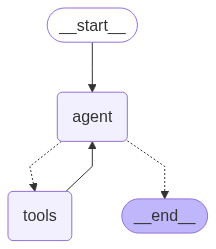

In [22]:
#ReAct Agent 구현

from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(
    model = llm_with_tools,        #우리가 가지고 있는 llm
    tools=tools,                    #아까 2개 툴 가진거
)

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
inputs = {
    "messages": [
        HumanMessage("연봉 5천만원 직장인의 소득세는 얼마인가요?")
    ]
}

messages = graph.invoke(inputs)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

연봉 5천만원 직장인의 소득세는 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_law (call_wMulbEUBr8SmFQswNNRNagCi)
 Call ID: call_wMulbEUBr8SmFQswNNRNagCi
  Args:
    query: 연봉 5000만원 소득세
================================= Tool Message =================================
Name: search_law

<Document href="./tax.docx">
④ 관할세무서장 또는 지방국세청장은 주소ㆍ거소 또는 사업장의 이동이 빈번하다고 인정되는 지역의 납세의무가 있는 자에 대해서는 제1항과 제2항을 준용하여 대통령령으로 정하는 바에 따라 수시부과할 수 있다.

⑤ 수시부과 절차와 그 밖에 필요한 사항은 대통령령으로 정한다.

[전문개정 2009. 12. 31.]



제83조(과세표준과 세액의 통지) 납세지 관할 세무서장 또는 지방국세청장은 제80조에 따라 거주자의 과세표준과 세액을 결정 또는 경정한 경우에는 그 내용을 해당 거주자 또는 상속인에게 대통령령으로 정하는 바에 따라 서면으로 통지하여야 한다. 다만, 제42조에 따라 과세표준과 세액의 결정 또는 경정을 한 경우에는 지체 없이 통지하여야 한다.

[전문개정 2009. 12. 31.]



제84조(기타소득의 과세최저한) 기타소득이 다음 각 호의 어느 하나에 해당하면 그 소득에 대한 소득세를 과세하지 아니한다. <개정 2014. 12. 23., 2015. 12. 15., 2022. 12. 31.>

1. 제21조제1항제4호에 따른 환급금으로서 건별로 승마투표권, 승자투표권, 

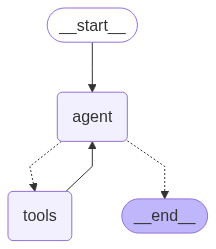

In [24]:
system_prompt = dedent("""
You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_law
    Action Input: 소득세 
    
    (After receiving tool output)
    [Source: search_lau | 소득세 | ./tax.docx]
    해당 연봉에 대한 소득세는 다음과 같습니다...

    Action: search_web
    Action Input: History of AI

    (After receiving tool output)
    [Source: search_web | AI History | https://en.wikipedia.org/wiki/History_of_artificial_intelligence]
    AI의 역사는 다음과 같이 요약됩니다...

If tool use is not necessary, answer directly.

Your final answer should be clear, concise, and directly related to the user's question. 
Ensure that every piece of factual information in your response is accompanied by a citation.

Remember: ALWAYS include these citations for all factual information, tool outputs, and referenced documents in your response. 
Do not provide any information without a corresponding citation.
""")

graph = create_react_agent(
    model = llm_with_tools,        #우리가 가지고 있는 llm
    tools=tools,                    #아까 2개 툴 가진거
    state_modifier=system_prompt,
)

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
inputs = {
    "messages": [
        HumanMessage("연봉 8천만원 직장인의 소득세는 얼마인가요?")
    ]
}

messages = graph.invoke(inputs)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

연봉 8천만원 직장인의 소득세는 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_law (call_tm9Z0t2Zq6n3jcWgbmTD2UuB)
 Call ID: call_tm9Z0t2Zq6n3jcWgbmTD2UuB
  Args:
    query: 소득세 연봉 8000만원
================================= Tool Message =================================
Name: search_law

<Document href="./tax.docx">
④ 관할세무서장 또는 지방국세청장은 주소ㆍ거소 또는 사업장의 이동이 빈번하다고 인정되는 지역의 납세의무가 있는 자에 대해서는 제1항과 제2항을 준용하여 대통령령으로 정하는 바에 따라 수시부과할 수 있다.

⑤ 수시부과 절차와 그 밖에 필요한 사항은 대통령령으로 정한다.

[전문개정 2009. 12. 31.]



제83조(과세표준과 세액의 통지) 납세지 관할 세무서장 또는 지방국세청장은 제80조에 따라 거주자의 과세표준과 세액을 결정 또는 경정한 경우에는 그 내용을 해당 거주자 또는 상속인에게 대통령령으로 정하는 바에 따라 서면으로 통지하여야 한다. 다만, 제42조에 따라 과세표준과 세액의 결정 또는 경정을 한 경우에는 지체 없이 통지하여야 한다.

[전문개정 2009. 12. 31.]



제84조(기타소득의 과세최저한) 기타소득이 다음 각 호의 어느 하나에 해당하면 그 소득에 대한 소득세를 과세하지 아니한다. <개정 2014. 12. 23., 2015. 12. 15., 2022. 12. 31.>

1. 제21조제1항제4호에 따른 환급금으로서 건별로 승마투표권, 승자투표권, 

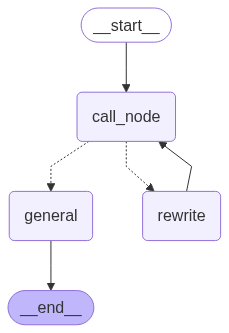

In [34]:
# create_react_agent을 하지 않고도 resoning하는 방법 => mesage state

from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser

class GraphState(MessagesState):
    pass       


def call_node(state: GraphState) -> GraphState:
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state["messages"]   
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}     


def general(state: GraphState) -> GraphState:
    response_template = """
    사용자 입력: {user_query}
    위 입력은 세법과 관련이 없습니다. 
    일반적인 대화 맥락에서 적절한 답변을 생성하세요.
    
    답변:
    """
    last_message = state['messages'][-1] 
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    # 체인 실행
    response = response_chain.invoke({"user_query": last_message or "질문을 찾을 수 없습니다."})
    
    # AIMessage로 반환
    return {"messages": [AIMessage(content=response)]}


def should_continue(state: GraphState):
    last_message = state['messages'][-1]        #라스트 메시지 받아서 도구 호출할지말지 정함
    if last_message.tool_calls: #툴 호출 필요하다면
        return "rewrite" #임의로 정하는 값 
    
    return END      #필요 없으면 도구호출 없이 끝내겠다. 
    
    
builder = StateGraph(GraphState)
builder.add_node("call_node", call_node)
builder.add_node("general", general)
builder.add_node("rewrite", ToolNode(tools=tools))       

builder.add_edge(START, "call_node")
builder.add_conditional_edges(
    "call_node",
    should_continue,
    {
        "rewrite" :"rewrite",
        "general": "general",
    }
)
builder.add_edge("rewrite", "call_node")
builder.add_edge("general", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
inputs = {
    "messages": [
        HumanMessage("연봉 8천만원 직장인의 소득세는 얼마인가요?")
    ]
}

messages = graph.invoke(inputs)
for message in messages['messages']:
    message.pretty_print()

KeyError: '__end__'